In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

from sklearn.decomposition import PCA

import warnings


In [2]:
# Suppress the specific warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, module='sklearn')


In [3]:
# Load the data
df = pd.read_csv('customer_data.csv')


In [4]:
# Display the first few rows of the dataset
print(df.head())


     ID  Year_Birth  Kidhome  Teenhome Dt_Customer  MntWines  MntFruits  \
0  5524        1957        0         0  21/11/2020      1587       2024   
1  2174        1954        1         1  25/05/2022       253         23   
2  5324        1981        1         0   7/04/2022      3979        989   
3   965        1971        0         1  30/01/2021      5405       1495   
4  6177        1985        1         0  25/07/2021      1748        230   

   MntMeatProducts  MntFishProducts  MntSweetProducts  ...  NumStorePurchases  \
0            12558             3956              2024  ...                  9   
1              138               46                23  ...                  6   
2             2714             1058               621  ...                 15   
3             3772             1150              1127  ...                 12   
4             1288               69                23  ...                  6   

   NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  Nu

In [5]:
# Columns
print(df.columns)


Index(['ID', 'Year_Birth', 'Kidhome', 'Teenhome', 'Dt_Customer', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntOtherProds', 'NumStorePurchases', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumWebVisitsMonth',
       'AcceptedCmp2', 'AcceptedCmp1', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5'],
      dtype='object')


In [6]:
# Select relevant columns ((variable 6 to 11))
cluster_raw_df = df[[
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
    'MntSweetProducts', 'MntOtherProds'
]]

In [7]:
print(cluster_raw_df.head())


   MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
0      1587       2024            12558             3956              2024   
1       253         23              138               46                23   
2      3979        989             2714             1058               621   
3      5405       1495             3772             1150              1127   
4      1748        230             1288               69                23   

   MntOtherProds  
0           2024  
1            138  
2            345  
3            621  
4            529  


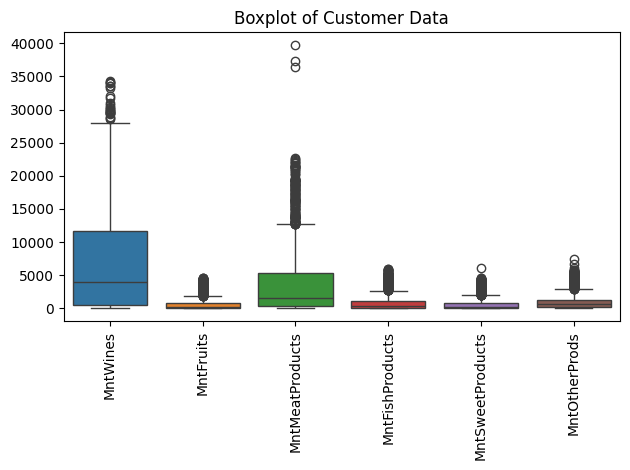

In [8]:
# Data Summary
sns.boxplot(data=cluster_raw_df)
plt.xticks(rotation=90)
plt.title('Boxplot of Customer Data')
plt.tight_layout()
plt.show()


In [9]:
# Check for problematic values before clustering
print("Data statistics before scaling:")
print(cluster_raw_df.describe())


Data statistics before scaling:
           MntWines    MntFruits  MntMeatProducts  MntFishProducts  \
count   1637.000000  1637.000000      1637.000000      1637.000000   
mean    6988.852779   612.752596      3849.036652       851.281002   
std     7781.592043   922.834522      5207.205389      1235.605815   
min        0.000000     0.000000         0.000000         0.000000   
25%      529.000000    46.000000       345.000000        69.000000   
50%     3979.000000   184.000000      1564.000000       276.000000   
75%    11615.000000   782.000000      5290.000000      1127.000000   
max    34339.000000  4577.000000     39675.000000      5957.000000   

       MntSweetProducts  MntOtherProds  
count       1637.000000    1637.000000  
mean         629.359805    1013.770312  
std          956.233865    1193.852000  
min            0.000000       0.000000  
25%           23.000000     207.000000  
50%          184.000000     575.000000  
75%          805.000000    1288.000000  
max      

In [10]:
print("Column Data Types: ")
print(cluster_raw_df.info())


Column Data Types: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1637 entries, 0 to 1636
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   MntWines          1637 non-null   int64
 1   MntFruits         1637 non-null   int64
 2   MntMeatProducts   1637 non-null   int64
 3   MntFishProducts   1637 non-null   int64
 4   MntSweetProducts  1637 non-null   int64
 5   MntOtherProds     1637 non-null   int64
dtypes: int64(6)
memory usage: 76.9 KB
None


In [11]:
# Check for zero or near-zero values
zero_cols = (cluster_raw_df == 0).sum()
print(f"Columns with zero values:\n{zero_cols}")


Columns with zero values:
MntWines             12
MntFruits           282
MntMeatProducts       1
MntFishProducts     277
MntSweetProducts    304
MntOtherProds        40
dtype: int64


Correlation matrix to check multicollinearity

Shows that correlations are below .8 so multicollinearity is no problem. 

Correlation below 0.8 is considered low correlation.


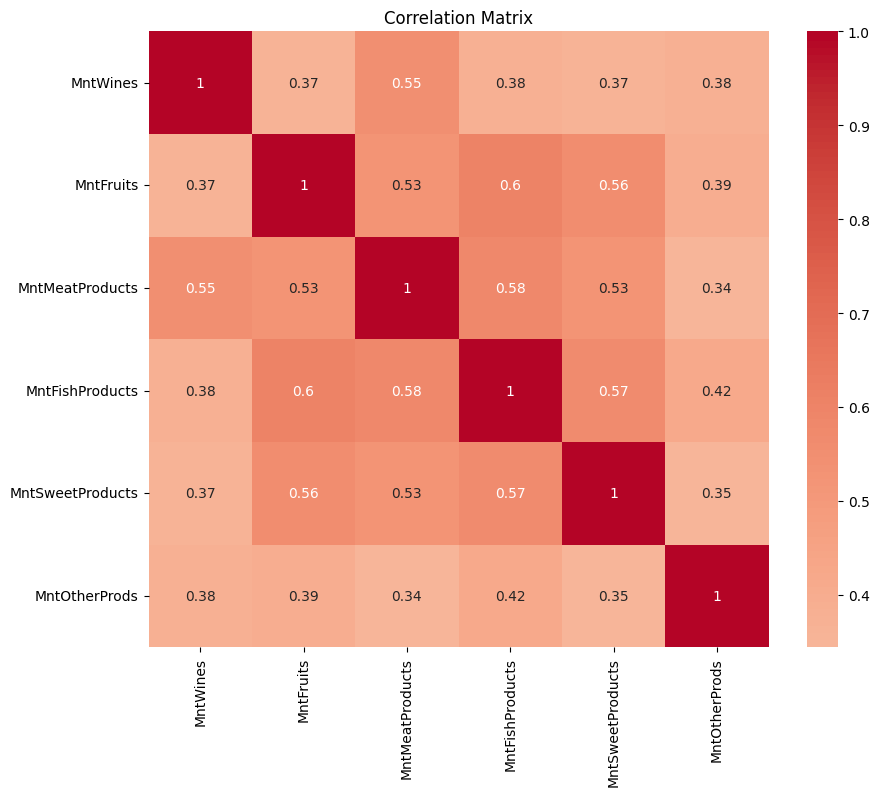

In [12]:
correlation_matrix = cluster_raw_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


No correlation value over 0.8. Each variable is distinct

In [13]:
# Add small constant to zero values if needed
cluster_raw_df_clean = cluster_raw_df.copy()
for col in cluster_raw_df_clean.columns:
    if cluster_raw_df_clean[col].min() == 0:
        cluster_raw_df_clean[col] = cluster_raw_df_clean[col] + 1e-8


In [14]:
# Standardize the data
scaler = StandardScaler()
cluster_raw_df_scaled = scaler.fit_transform(cluster_raw_df)

# Add small epsilon to prevent division by zero
epsilon = 1e-10
cluster_raw_df_scaled = cluster_raw_df_scaled + epsilon

print(f'\ncluster_raw_df_scaled: \n{cluster_raw_df_scaled}')
cluster_scaled_df = pd.DataFrame(cluster_raw_df_scaled, columns=cluster_raw_df.columns)

print(f'\ncluster_scaled_df: \n{cluster_scaled_df}')



cluster_raw_df_scaled: 
[[-0.69439562  1.52972024  1.67299424  2.51347775  1.45891755  0.84645198]
 [-0.86587822 -0.63926175 -0.71289115 -0.65192885 -0.63430623 -0.73379106]
 [-0.38690958  0.40783301 -0.21804085  0.16735286 -0.0087451  -0.56034975]
 ...
 [ 1.19782617  0.40783301  0.06473075  0.0928727   2.18071885  3.91058178]
 [ 1.78618889  0.53248714  0.21937147 -0.09332768 -0.36964575 -0.38690844]
 [-0.65004668 -0.58940009 -0.46988431 -0.65192885 -0.63430623 -0.44472221]]

cluster_scaled_df: 
      MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
0    -0.694396   1.529720         1.672994         2.513478          1.458918   
1    -0.865878  -0.639262        -0.712891        -0.651929         -0.634306   
2    -0.386910   0.407833        -0.218041         0.167353         -0.008745   
3    -0.203601   0.956311        -0.014799         0.241833          0.520576   
4    -0.673699  -0.414884        -0.491976        -0.633309         -0.634306   
...        .

In [15]:
# Hiercharical Clustering Analysis
# Calculate distance and linkage
distances_matrix = pdist(cluster_scaled_df, metric='euclidean')
linkage_matrix = linkage(distances_matrix, method='ward')


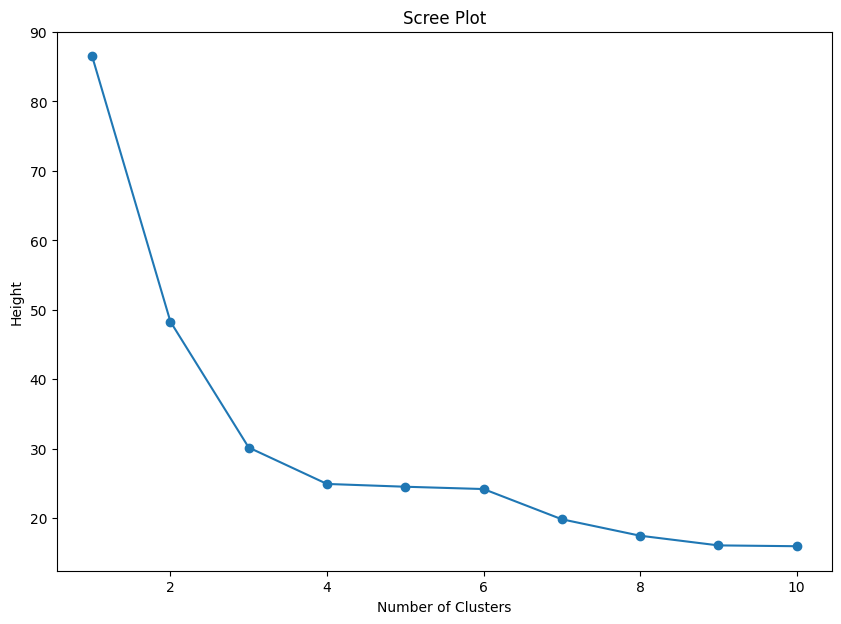

In [16]:
# Plot the Scree Plot
# This helps with elbow method to decide the number of clusters
# We can see that there are elbows at 3 clusters and 4 clusters
heights = linkage_matrix[:, 2]

plt.figure(figsize=(10, 7))
plt.plot(range(10, 0, -1), heights[-10:], marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Height')
plt.show()


There are elbows at cluster size at 3 and 4. Therefore, we can use these 2 numbers as our K

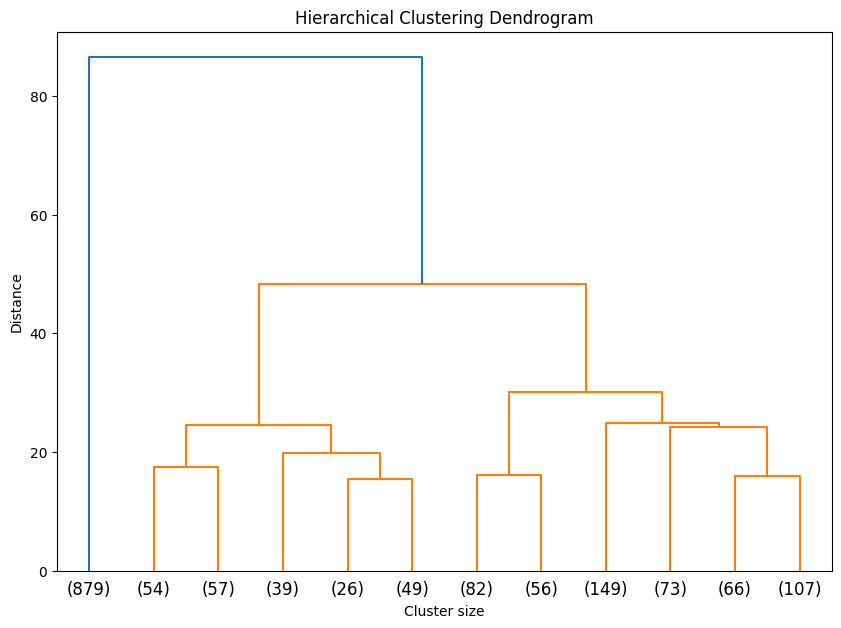

In [17]:
# Plot the dendrogram
# We can see there can be either 3 big clusters or 4 big clusters from the graph
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=cluster_scaled_df.index, truncate_mode='lastp', p=12)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()


We can see there can be 3 big clusters from the graph based on the dendrogram


# K-means Clustering

In [18]:
# K-means Clustering
kmeans_3 = KMeans(n_clusters=3, random_state=42)
kmeans_4 = KMeans(n_clusters=4, random_state=42)

kmeans_3.fit(cluster_scaled_df)
kmeans_4.fit(cluster_scaled_df)

# Cluster size for 3 clusters and 4 clusters
print("K-Means Clustering with 3 clusters: ", np.bincount(kmeans_3.labels_)) # [961 400 276]
print("K-Means Clustering with 4 clusters: ", np.bincount(kmeans_4.labels_)) # [340 225 155 917]


K-Means Clustering with 3 clusters:  [961 400 276]
K-Means Clustering with 4 clusters:  [340 225 155 917]


In [19]:
# Cluster means for 3 clusters
cluster_means_3 = cluster_raw_df.groupby(kmeans_3.labels_).mean()
print(f'cluster_means_3: \n{cluster_means_3}')

# Cluster means for 4 clusters
cluster_means_4 = cluster_raw_df.groupby(kmeans_4.labels_).mean()
print(f'\ncluster_means_4: \n{cluster_means_4}')


cluster_means_3: 
       MntWines    MntFruits  MntMeatProducts  MntFishProducts  \
0   2218.028096   155.997919       827.353798       207.454735   
1  15635.285000   704.950000      7005.225000      1063.175000   
2  11069.250000  2069.500000      9796.000000      2785.916667   

   MntSweetProducts  MntOtherProds  
0        153.724246     429.197711  
1        699.027500    1718.215000  
2       2184.500000    2028.250000  

cluster_means_4: 
       MntWines    MntFruits  MntMeatProducts  MntFishProducts  \
0  14795.967647   525.955882      4394.285294       711.241176   
1  13510.915556  1689.631111     12362.857778      2546.866667   
2  10718.593548  1946.838710      8425.716129      2533.412903   
3   1863.451472   155.206107       784.282443       202.836423   

   MntSweetProducts  MntOtherProds  
0        580.073529    1837.091176  
1        999.528889    1565.737778  
2       3018.935484    2153.541935  
3        152.898582     380.415485  


In [20]:
# Add cluster labels to df
cluster_raw_df_with_clusters = cluster_raw_df.copy()
cluster_raw_df_with_clusters['cluster_3'] = kmeans_3.labels_
cluster_raw_df_with_clusters['cluster_4'] = kmeans_4.labels_
print(f'cluster_raw_df_with_clusters: \n{cluster_raw_df_with_clusters}')



cluster_raw_df_with_clusters: 
      MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
0         1587       2024            12558             3956              2024   
1          253         23              138               46                23   
2         3979        989             2714             1058               621   
3         5405       1495             3772             1150              1127   
4         1748        230             1288               69                23   
...        ...        ...              ...              ...               ...   
1632       115         23              138               69                92   
1633        69         69              161              138                46   
1634     16307        989             4186              966              2714   
1635     20884       1104             4991              736               276   
1636      1932         69             1403               46                23 

# Visualize clusters using PCA

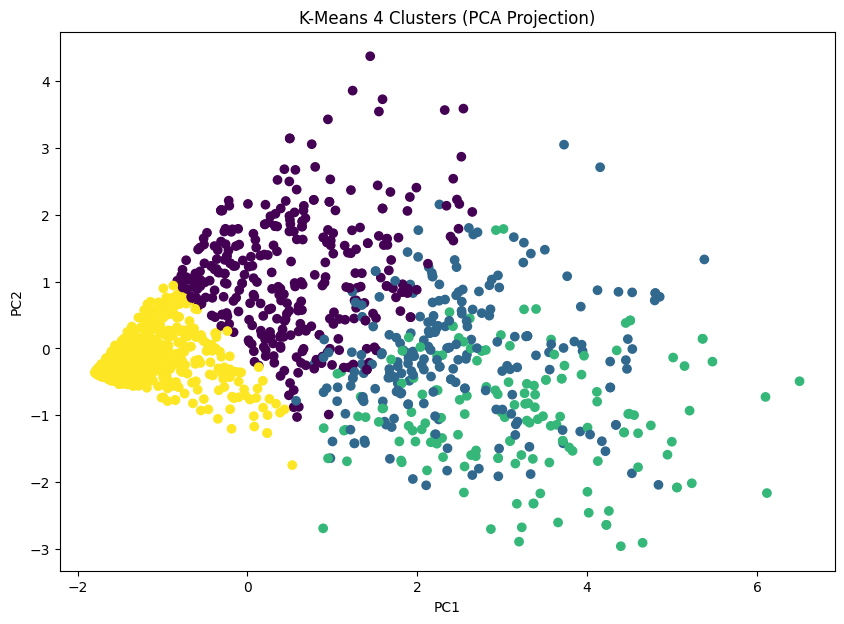

In [21]:
# Visualize clusters using PCA

# 4 Clusters
pca = PCA(n_components=2)
components = pca.fit_transform(cluster_scaled_df)

plt.figure(figsize=(10, 7))
plt.scatter(components[:, 0], components[:, 1], c=kmeans_4.labels_, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means 4 Clusters (PCA Projection)')
plt.show()


We can see some clusters are overrlapping with each other in 4 clusters

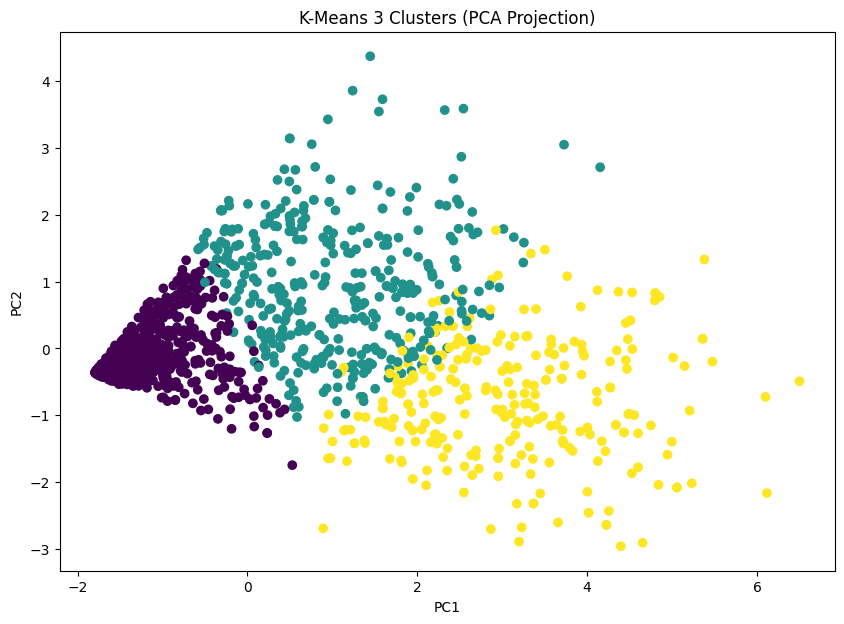

In [22]:
# Visualize clusters using PCA
# 3 Clusters
pca = PCA(n_components=2)
components = pca.fit_transform(cluster_scaled_df)

plt.figure(figsize=(10, 7))
plt.scatter(components[:, 0], components[:, 1], c=kmeans_3.labels_, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means 3 Clusters (PCA Projection)')
plt.show()

We can see with 3 clusters, clusters are more differentiated.
Therefore, for the analysis, we will go with 3 clusters

In [23]:
# We will only use 3 clusters
cluster_raw_df_with_clusters.drop(columns=['cluster_4'], inplace=True)


In [24]:
# Create a total column to combine all purchase amount
purchase_amount_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntOtherProds']
cluster_raw_df_with_clusters['total_purchase_amount'] = cluster_raw_df_with_clusters[purchase_amount_columns].sum(axis=1)
print(f'cluster_raw_df_with_clusters: \n{cluster_raw_df_with_clusters}')


cluster_raw_df_with_clusters: 
      MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
0         1587       2024            12558             3956              2024   
1          253         23              138               46                23   
2         3979        989             2714             1058               621   
3         5405       1495             3772             1150              1127   
4         1748        230             1288               69                23   
...        ...        ...              ...              ...               ...   
1632       115         23              138               69                92   
1633        69         69              161              138                46   
1634     16307        989             4186              966              2714   
1635     20884       1104             4991              736               276   
1636      1932         69             1403               46                23 

# Final Cluster Group Statistics

In [25]:
# Average value by column by cluster group
print(cluster_raw_df_with_clusters.groupby('cluster_3').mean())

               MntWines    MntFruits  MntMeatProducts  MntFishProducts  \
cluster_3                                                                
0           2218.028096   155.997919       827.353798       207.454735   
1          15635.285000   704.950000      7005.225000      1063.175000   
2          11069.250000  2069.500000      9796.000000      2785.916667   

           MntSweetProducts  MntOtherProds  total_purchase_amount  
cluster_3                                                          
0                153.724246     429.197711            3991.756504  
1                699.027500    1718.215000           26825.877500  
2               2184.500000    2028.250000           29933.416667  


# Cluster Characteristics

The cluster group 0 (Not-so-profitable customer) tends to spend the least on all categories compared with other 2 cluster 

groups. 

The cluster group 1 (Most valueable customer) tends to spend the most on all categories except wines.

The cluster group 2 (Wine lovers) tends to spend the most on wines compared with other cluster group.

# Recommendation

For the cluster group 0, we are suggesting to provide coupon discounts such as buying X amount to get y % discount on purchases 

to persuade this cluster group to increase the spending on all categories.



For the cluster group 1, we are suggesting to provide recipes that use wines with other products in V2 - V6 categories together 

to make delicious cuisines to our customers so that this cluster group may be more likely to increase on the consumption of 

wines if they get interested in making such cuisines. For example, we can try to introduce recipes that can use wine and fish as 

ingredients to create the cuisines so that if the customers in this cluster group get interested in the recipes they can 

purchase not only wine but also fish products as well. This can be a good way to boost some sales in wine categories together 

with other categories of products.



For the cluster group 2, we are suggesting to provide recipes that use the products in V2 - V6 categories together to make  

delicious cuisines and provide the bundle sales based on the combination of products suggested to use in the given recipes for 

the opportunity to up-sale. Also, we are suggesting to provide discounts based on the association of products in V2-V6 and V1. 

For example, if we want to boost the sales of meat and fish from this cluster group, we can provide the coupon discounts such 

that if the customer buys meat/fish for at least X amount of money the supermarket will offer to 

provide Y amount of discounts for the wines purchases. As we know that this cluster group buys considerably more on wine and 

less on other category of products such as meat and fish, by doing this way, we can persuade this wine loving 

cluster group to purchase more on different categories of products.